# Goal
- Find false innocents, could be through:
    - connections with many criminal nodes?
    - connection to a big criminal hub?

# Assumptions
- People connected to a crime as suspect or suspect/victim will be considered as being guilty of the crime they are connected to
- 

## Node categorisation
- criminal nodes: nodes that have been a suspect in a acrime at least once
- innocent nodes: nodes that have been only victims and/or witness

## Suspect role


# Work plan
Research question: is it possible to detect criminals that were not previously caught? - "criminal" disguised as "innocent"

- Does a strong link prediction between a criminal and an innocent suggests that the innocent might be a criminal in disguise?
- Compare the results from link prediction and community detection
- If they are in the same community? Is that an even stronger indication of a possible criminal?

# Imports

In [1]:
import pandas as pd
import statistics as stats
import numpy as np

import networkx as nx
from networkx.algorithms import bipartite

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print('seaborn version', sns.__version__)
print('pandas version', pd.__version__)

seaborn version 0.11.2
pandas version 1.3.4


# Read data

In [3]:
al = '..//Data//out.moreno_crime_crime'
gender = '..//Data//ent.moreno_crime_crime.person.sex'
name = '..//Data//ent.moreno_crime_crime.person.name'
role = '..//Data//rel.moreno_crime_crime.person.role'

## Adjancency list as DataFrame

In [4]:
df_al = pd.read_csv(al, sep=" ", names=['person', 'crime'], index_col=False)
df_al['person'] = 'p' + df_al['person'].astype(str)
df_al['crime'] = 'c' + df_al['crime'].astype(str)
df_al.head(3)
df_al.shape

(1476, 2)

## Gender Dataframe

In [5]:
df_gender = pd.read_csv(gender, sep=" ", header=None, names=['gender'])
df_gender['person'] = 'p' + df_gender.index.astype(str)
df_gender.head(3)

,gender,person
0,1,p0
1,1,p1
2,1,p2


## Name DataFrame

In [6]:
df_name = pd.read_csv(name, sep=" ", header=None, names=['name'])
df_name['person'] = 'p' + df_name.index.astype(str)
df_name.head(3)

,name,person
0,AbelDennis,p0
1,AbramsChad,p1
2,AbramsDavid,p2


## Role Dataframe

In [7]:
df_role = pd.read_csv(role, sep=",", header=None, names=['role'])
df_role.head(3)
# df_role.shape

,role
0,Suspect
1,Victim
2,Victim


## Join adjancency list with role

In [8]:
df_al_roles = df_al.join(df_role)
df_al_roles.head(3)

,person,crime,role
0,p1,c1,Suspect
1,p1,c2,Victim
2,p1,c3,Victim


In [9]:
df_al_roles[df_al_roles['person'] == 'p336']

,person,crime,role
594,p336,c40,Victim
595,p336,c354,Victim
596,p336,c322,Victim
597,p336,c355,Victim
598,p336,c356,Victim
599,p336,c357,Victim
600,p336,c46,Witness
601,p336,c358,Suspect
602,p336,c4,Victim


In [10]:
s = [1,2,3,4]
if 2 in s:
    print('guilty')
else:
    print('innocent')

guilty


In [11]:
# group bys gives us the same as degree distribution
# df_al_roles.groupby(by='person', dropna=False).count()
# df_al_roles.groupby(by=['crime', 'role'], dropna=False).count()

## Basic data stats

In [12]:
# the following are used to create the graph
people = df_al['person'].unique()
crimes = df_al['crime'].unique()
roles = df_role['role'].unique()

# print stats
print('Number of people:', len(people))
print('Number of crimes:', len(crimes))
print('Number of roles:', len(roles))
print('Number of edges:', len(df_al_roles))


Number of people: 829
Number of crimes: 551
Number of roles: 4
Number of edges: 1476


Breakdown of roles

In [13]:
df_role.value_counts()

role          
Suspect           682
Victim            558
Witness           195
Victim Suspect     41
dtype: int64

# Make graph

In [14]:
# G=nx.from_pandas_dataframe(df_al_roles, 0, 'b', ['weight', 'cost'])

In [15]:
# create networkx graph
G = nx.Graph()

# # add nodes
for i in range(len(people)):
    G.add_node(people[i], name=df_name['name'][i], gender=df_gender['gender'][i], bipartite=0)

for i in range(len(crimes)):
    G.add_node(crimes[i], bipartite=1)

# # add edges
for i in range(len(df_al)):
    G.add_edge(df_al_roles['person'][i], df_al_roles['crime'][i], role=df_al_roles['role'][i])

## Assign node status

In [58]:
# Code from Dee
# Initialize a dictionary based on people nodes to keep track of all roles per node
p_nodes = {el:[] for el in people}

# Add all the edge attributes to a dictionary of people nodes
for key,value in nx.get_edge_attributes(G, 'role').items():
    for part in key:
        if part in people:
            p_nodes[part].append(value)

# print(p_nodes['p1']) # List of all roles from p1

# Initialize a dictionary to keep track of who is a "criminal"
status = {el:[] for el in people}
    
# Loop through all roles per node, and deem them criminals if ever they have been a suspect
for key in p_nodes:
    if 'Suspect' in p_nodes[key]:
        status[key] = "criminal"
    elif 'Victim Suspect' in p_nodes[key]:
        status[key] = "criminal"
    else:
        status[key] = "innocent"

print(status['p336']) # Verify that p1 is deemed "criminal"

# Convert to pandas df
criminals_df = pd.DataFrame(status.items(), columns=['node', 'criminal_status'])

criminal


## Add node status

In [59]:
# loop through rows in the data frame and add the attribute of Criminal Status
for index, row in criminals_df.iterrows():
    #print(row['node'])
    G.nodes[row['node']]['criminal_status'] = row['criminal_status']

print(nx.get_node_attributes(G, 'criminal_status')['p1']) # check name of person 'p1' = 'Criminal'

criminal


In [60]:
# get top and bottom nodes for projection and plotting
people_nodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}
crime_nodes = set(G) - people_nodes

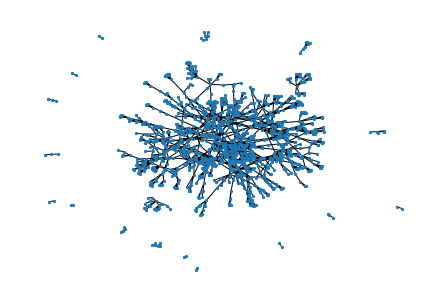

In [61]:
# plot only biggest component
# pos = nx.spring_layout(G)
# posB = nx.bipartite_layout(G, people_nodes)
G_draw = nx.draw_spring(G,node_size=5)

## Get degree of all nodes
Node degreee of **people** nodes if the number of crimes they were involved in.  
Node degree of **crime** nodes is the number of people involved in the crime.

In [62]:
# Creating dict with all node degrees to add as attribute
node_degrees = dict()

# Creating dict for each node type
people_degrees = dict()
crimes_degrees = dict()

# for loop to populate dicts above
for node in G.nodes:
    # print(G.edges(node, data=True))
    node_degrees[node] = G.degree(node)
    if node.startswith('p') == True:
        people_degrees[node] = G.degree(node)
    else:
        crimes_degrees[node] = G.degree(node)

In [63]:
df_gender = pd.read_csv(gender, sep=" ", header=None, names=['gender'])
df_gender['person'] = 'p' + df_gender.index.astype(str)
df_gender.head(3)

,gender,person
0,1,p0
1,1,p1
2,1,p2


In [64]:
# Add node degree as node attribute in graph G
nx.set_node_attributes(G, node_degrees, "node_degree")

# and check it worked
# nx.get_node_attributes(G, 'node_degree')

### Make a dataframe including all node attributes

In [67]:
# code from https://stackoverflow.com/a/50775962
# make pandas dataframe from graph with node attributes
df_G = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_G
# df_G['criminal_status'].value_counts()

,name,gender,bipartite,criminal_status,node_degree
p1,AbelDennis,1.0,0,criminal,4
p2,AbramsChad,1.0,0,criminal,22
p3,AbramsDavid,1.0,0,criminal,1
p4,AbramsDon,1.0,0,criminal,1
p5,AbramsRichard,1.0,0,innocent,1
...,...,...,...,...,...
c547,NaN,NaN,1,NaN,1
c548,NaN,NaN,1,NaN,1
c549,NaN,NaN,1,NaN,1
c550,NaN,NaN,1,NaN,1


# Projection on people

In [68]:
G_proj = bipartite.weighted_projected_graph(G, people_nodes, ratio=False)
list(G_proj.edges(data=True))[0:5]

[('p204', 'p788', {'weight': 1}),
 ('p204', 'p577', {'weight': 1}),
 ('p215', 'p216', {'weight': 1}),
 ('p161', 'p88', {'weight': 1}),
 ('p166', 'p62', {'weight': 1})]

In [69]:
print(
    'Num. of nodes: {} \nNum. of edges: {} \nIs bipartite? {} \nIs connected? {}'.format(
        G_proj.number_of_nodes(), 
        G_proj.number_of_edges(), 
        nx.is_bipartite(G_proj),
        nx.is_connected(G_proj)
        )
    )

Num. of nodes: 829 
Num. of edges: 2253 
Is bipartite? False 
Is connected? False


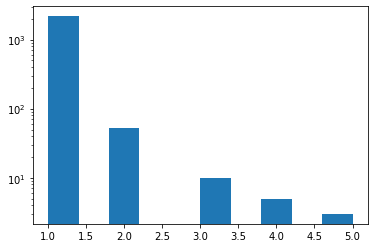

In [70]:
weights = list(nx.get_edge_attributes(G_proj, 'weight').values())

# plot weights
plt.hist(weights, bins = 10, log=True)
plt.show()

People of interest. Pairs that are connected by 5 crimes.

In [71]:
edge_w = list(G_proj.edges(data=True))

for i in edge_w:
    if i[2]['weight'] > 2:
        print(i)

('p344', 'p696', {'weight': 3})
('p56', 'p303', {'weight': 3})
('p87', 'p659', {'weight': 4})
('p425', 'p413', {'weight': 4})
('p425', 'p695', {'weight': 3})
('p425', 'p715', {'weight': 5})
('p425', 'p54', {'weight': 3})
('p572', 'p533', {'weight': 4})
('p2', 'p67', {'weight': 4})
('p79', 'p767', {'weight': 5})
('p17', 'p514', {'weight': 4})
('p695', 'p413', {'weight': 3})
('p695', 'p715', {'weight': 3})
('p815', 'p663', {'weight': 3})
('p128', 'p531', {'weight': 5})
('p37', 'p797', {'weight': 3})
('p592', 'p333', {'weight': 3})
('p396', 'p531', {'weight': 3})


In [72]:
# get adjacency matrix
A = nx.adjacency_matrix(G_proj, weight='weight')
A = A.toarray()

In [73]:
A[A > 2]

array([3, 3, 4, 3, 3, 4, 5, 4, 4, 3, 5, 4, 3, 3, 3, 3, 4, 3, 3, 3, 5, 3,
       4, 4, 3, 4, 3, 3, 4, 5, 3, 5, 3, 3, 5, 3], dtype=int32)

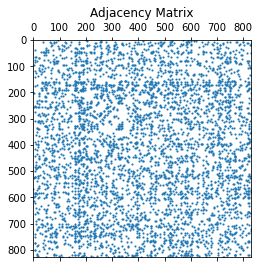

In [74]:
# plot adjacency matrix
plt.title('Adjacency Matrix')
# plt.imshow(A, cmap='Greys', markersize = 3)
# plt.show()
# plt.figure(figsize=(8,8))
plt.spy(A, markersize = 1)
plt.show()

<AxesSubplot:>

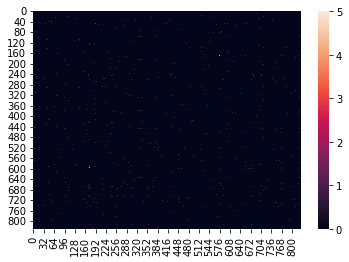

In [75]:
sns.heatmap(A)

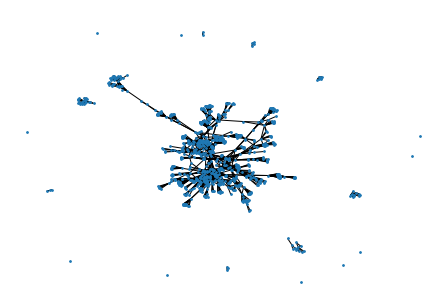

In [76]:
# plot graph visualisation
nx.draw_spring(G_proj, node_size=3)

# Link prediction on projected graph

Code from: https://www.networkatlas.eu/exercise.htm?c=20&e=1

In [77]:
linkpred_pa = list(nx.preferential_attachment(G_proj))

In [78]:
# Sort in decreasing score
linkpred_pa.sort(key = lambda tup: tup[2], reverse = True)

In [79]:
# Get the top 10
for edge_score in linkpred_pa[:10]:
   print(edge_score)

('p425', 'p2', 2448)
('p425', 'p356', 2244)
('p56', 'p2', 1584)
('p2', 'p695', 1584)
('p56', 'p356', 1452)
('p695', 'p356', 1452)
('p2', 'p497', 1440)
('p425', 'p10', 1428)
('p2', 'p715', 1392)
('p425', 'p815', 1377)


Code from: https://www.networkatlas.eu/exercise.htm?c=20&e=2

In [80]:
# Run the other link prediction methods implemented in networkx
linkpred_ja = list(nx.jaccard_coefficient(G_proj))
linkpred_aa = list(nx.adamic_adar_index(G_proj))
linkpred_ra = list(nx.resource_allocation_index(G_proj))

linkpred_ja.sort(key = lambda tup: tup[2], reverse = True)
linkpred_aa.sort(key = lambda tup: tup[2], reverse = True)
linkpred_ra.sort(key = lambda tup: tup[2], reverse = True)

In [81]:
# Print top predictions
print("PrefAtt\tJaccard\tAdamAd\tResAll")
for i in range(5):
   print("%s\t%s\t%s\t%s" % (linkpred_pa[i], linkpred_ja[i], linkpred_aa[i], linkpred_ra[i]))

PrefAtt	Jaccard	AdamAd	ResAll
('p425', 'p2', 2448)	('p645', 'p555', 1.0)	('p336', 'p815', 2.326022992233796)	('p336', 'p815', 0.7083333333333334)
('p425', 'p356', 2244)	('p645', 'p382', 1.0)	('p365', 'p114', 1.6072172535335318)	('p215', 'p214', 0.5)
('p56', 'p2', 1584)	('p645', 'p383', 1.0)	('p680', 'p466', 1.461880214172278)	('p237', 'p74', 0.5)
('p2', 'p695', 1584)	('p565', 'p359', 1.0)	('p680', 'p245', 1.461880214172278)	('p155', 'p269', 0.5)
('p56', 'p356', 1452)	('p591', 'p295', 1.0)	('p746', 'p805', 1.461880214172278)	('p695', 'p691', 0.5)


In [94]:
df_linkpred = pd.DataFrame(linkpred_ra, columns=['node1', 'node2', 'resource_allocation_score'])
df_linkpred['node1_status'] = df_linkpred['node1'].map(status)
df_linkpred['node2_status'] = df_linkpred['node2'].map(status)
# df_linkpred


In [93]:
df_linkpred[:10]

,node1,node2,resource_allocation_score,node1_status,node2_status
0,p336,p815,0.708333,criminal,criminal
1,p215,p214,0.500000,criminal,criminal
2,p237,p74,0.500000,innocent,criminal
3,p155,p269,0.500000,innocent,criminal
4,p695,p691,0.500000,criminal,criminal
5,p690,p132,0.500000,criminal,innocent
6,p815,p301,0.500000,criminal,innocent
7,p228,p514,0.500000,criminal,criminal
8,p797,p293,0.500000,criminal,innocent
9,p411,p283,0.458333,criminal,criminal


In [95]:
# df_linkpred[df_linkpred['resource_allocation_score'] != 0]

In [96]:
# sns.displot(df_linkpred[df_linkpred['resource_allocation_score'] > .25])

In [97]:
df_G.iloc[410,:]

name               JohnsonDennis
gender                       1.0
bipartite                      0
criminal_status         criminal
node_degree                    3
Name: p411, dtype: object

In [98]:
df_G.iloc[282,:]

name               GellarLindsay
gender                       0.0
bipartite                      0
criminal_status         criminal
node_degree                    2
Name: p283, dtype: object